# Image Classifier Evaluation
## Focus & Astigmatism Performance Analysis

- **Author:** [Aaron Woods](https://aaronwoods.info)
- **Date Created:** October 26, 2023
- **Objective:** This notebook is designated for the evaluation phase, concentrating on in-depth analysis of the model's performance and application in real-world scenarios.

## Evaluation Agenda
1. **Model Loading**: Retrieve the trained model for analysis.
2. **Performance Metrics Analysis**: Examine key performance indicators and metrics.
3. **Real-world Testing**: Validate model efficacy in practical scenarios.

## Further Actions
- Based on the outcomes and insights obtained here, consider revisiting the [Training Notebook](AI_Classify_Train_v1.ipynb) to refine or retrain the model, if necessary.


In [1]:
# Setup Instructions
# 1. Run the shared setup script to prepare the environment and integrate dependencies.
# 2. Execute the setup configurations.

# Import and run the setup function from the setup module
from setup import setup
setup()


GPU support is configured for TensorFlow.
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX A2000 8GB Laptop GPU, compute capability 8.6
Mixed precision policy set to 'mixed_float16'.
Platform: Windows-10-10.0.22621-SP0
Python Version: 3.9.18
TensorFlow Version: 2.10.1
Num GPUs Available: 1


In [2]:
# Standard Libraries
import os
import sys
import random
import math
import glob
import logging
import pickle
from datetime import datetime
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Union, Any, Optional

# Data Manipulation and Numerical Libraries
import numpy as np
import pandas as pd

# Machine Learning and Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils import class_weight, resample
from sklearn.metrics import confusion_matrix

# Deep Learning with TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, applications

# Image Processing and Visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sns
import itertools

### 0. Configuration

In [3]:
# Configuration

# Experiment Configuration: Sets up the experiment name, random seed, and problem type.
experiment_config = {
    'NAME': "Oct26_100pct_CW_SIM",        
    'RANDOM_SEED': 42,                      # Seed for reproducibility
    'PROBLEM_TYPE': 'Multi-Output',         # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
}

# Model Configuration: Sets up the model parameters.
model_config = {
    'IMG_SIZE': 224,                        # Image input size
    'BATCH_SIZE': 16,                       # Batch size for training
    'TRAIN_SIZE': 0.8,                      # Fraction of data to use for training
    'VAL_SIZE': 0.5,                        # Fraction of data to use for validation
    'EPOCHS': 100,                          # Number of training epochs
    'LEARNING_RATE': 0.001,                 # Learning rate
    'EARLY_STOPPING_PATIENCE': 50,          # Early stopping patience
    'REDUCE_LR_PATIENCE': 3,                # Reduce learning rate on plateau patience
    'MIN_LR': 1e-6,                         # Minimum learning rate
}

# Label Mapping Configuration: Sets up the label mapping for the dataset. (Optional)
label_mappings = {
    'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
    'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
    'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
}

# Augmentation Configuration: Sets up the augmentation parameters.
augmentation_config = {
    'rotation_factor': 0.002,           # Rotation range (radians)
    'height_factor': (-0.18, 0.18),      # Vertical shift range
    'width_factor': (-0.18, 0.18),       # Horizontal shift range
    'contrast_factor': 0.5,              # Contrast adjustment range
}

# Combine Experiment, Model, Labels, and Augmentation Configurations
config = {
    'Experiment': experiment_config,
    'Model': model_config,
    'Labels': {'MAPPINGS': label_mappings},
    'Augmentation': augmentation_config
}

# Dataset Creation Configuration
csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,                              # Lower focus threshold
        'FOCUS_HIGH': 60,                             # Upper focus threshold
        'STIGX_LOW': 1,                               # Lower astigmatism threshold (X)
        'STIGX_HIGH': 2,                              # Upper astigmatism threshold (X)
        'STIGY_LOW': 1,                               # Lower astigmatism threshold (Y)
        'STIGY_HIGH': 2,                              # Upper astigmatism threshold (Y)
    },
    'Paths': {
        'OLD_BASE_PATH': "D:\\DOE\\",
        # On Simulation Computer
        # 'DATA_FILE': "combined_output.csv", # Simulation Computer
        'DATA_FILE': "combined_output_cleaned.csv", # Laptop
        # 'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\",  # Simulation Computer
        'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\", # Laptop
    },
    'SAMPLE_FRAC': 0.1,                                # Fraction of the data for quicker prototyping (1.0 means use all data)
}

# Update the main configuration dictionary with the dataset configuration
config.update(csv_config)

# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

In [8]:
import tensorflow as tf

# Load the dataset from a specified folder with a given name

def load_dataset(folder_path, dataset_name):
    """
    Loads a TensorFlow dataset from a specified folder with a given name.
    """
    # Construct the full path for the dataset
    full_path = os.path.join(folder_path, dataset_name)
    try:
        dataset = tf.data.Dataset.load(full_path)
        print(f"Dataset '{dataset_name}' loaded successfully from '{folder_path}'.")
        return dataset
    except Exception as e:
        print(f"Error loading dataset '{dataset_name}': {e}")
        return None

# Example usage:
train_dataset = load_dataset('datasets', 'train_dataset')
valid_dataset = load_dataset('datasets', 'valid_dataset')
test_dataset = load_dataset('datasets', 'test_dataset')


### 1. Evaluating Classification Models During Training

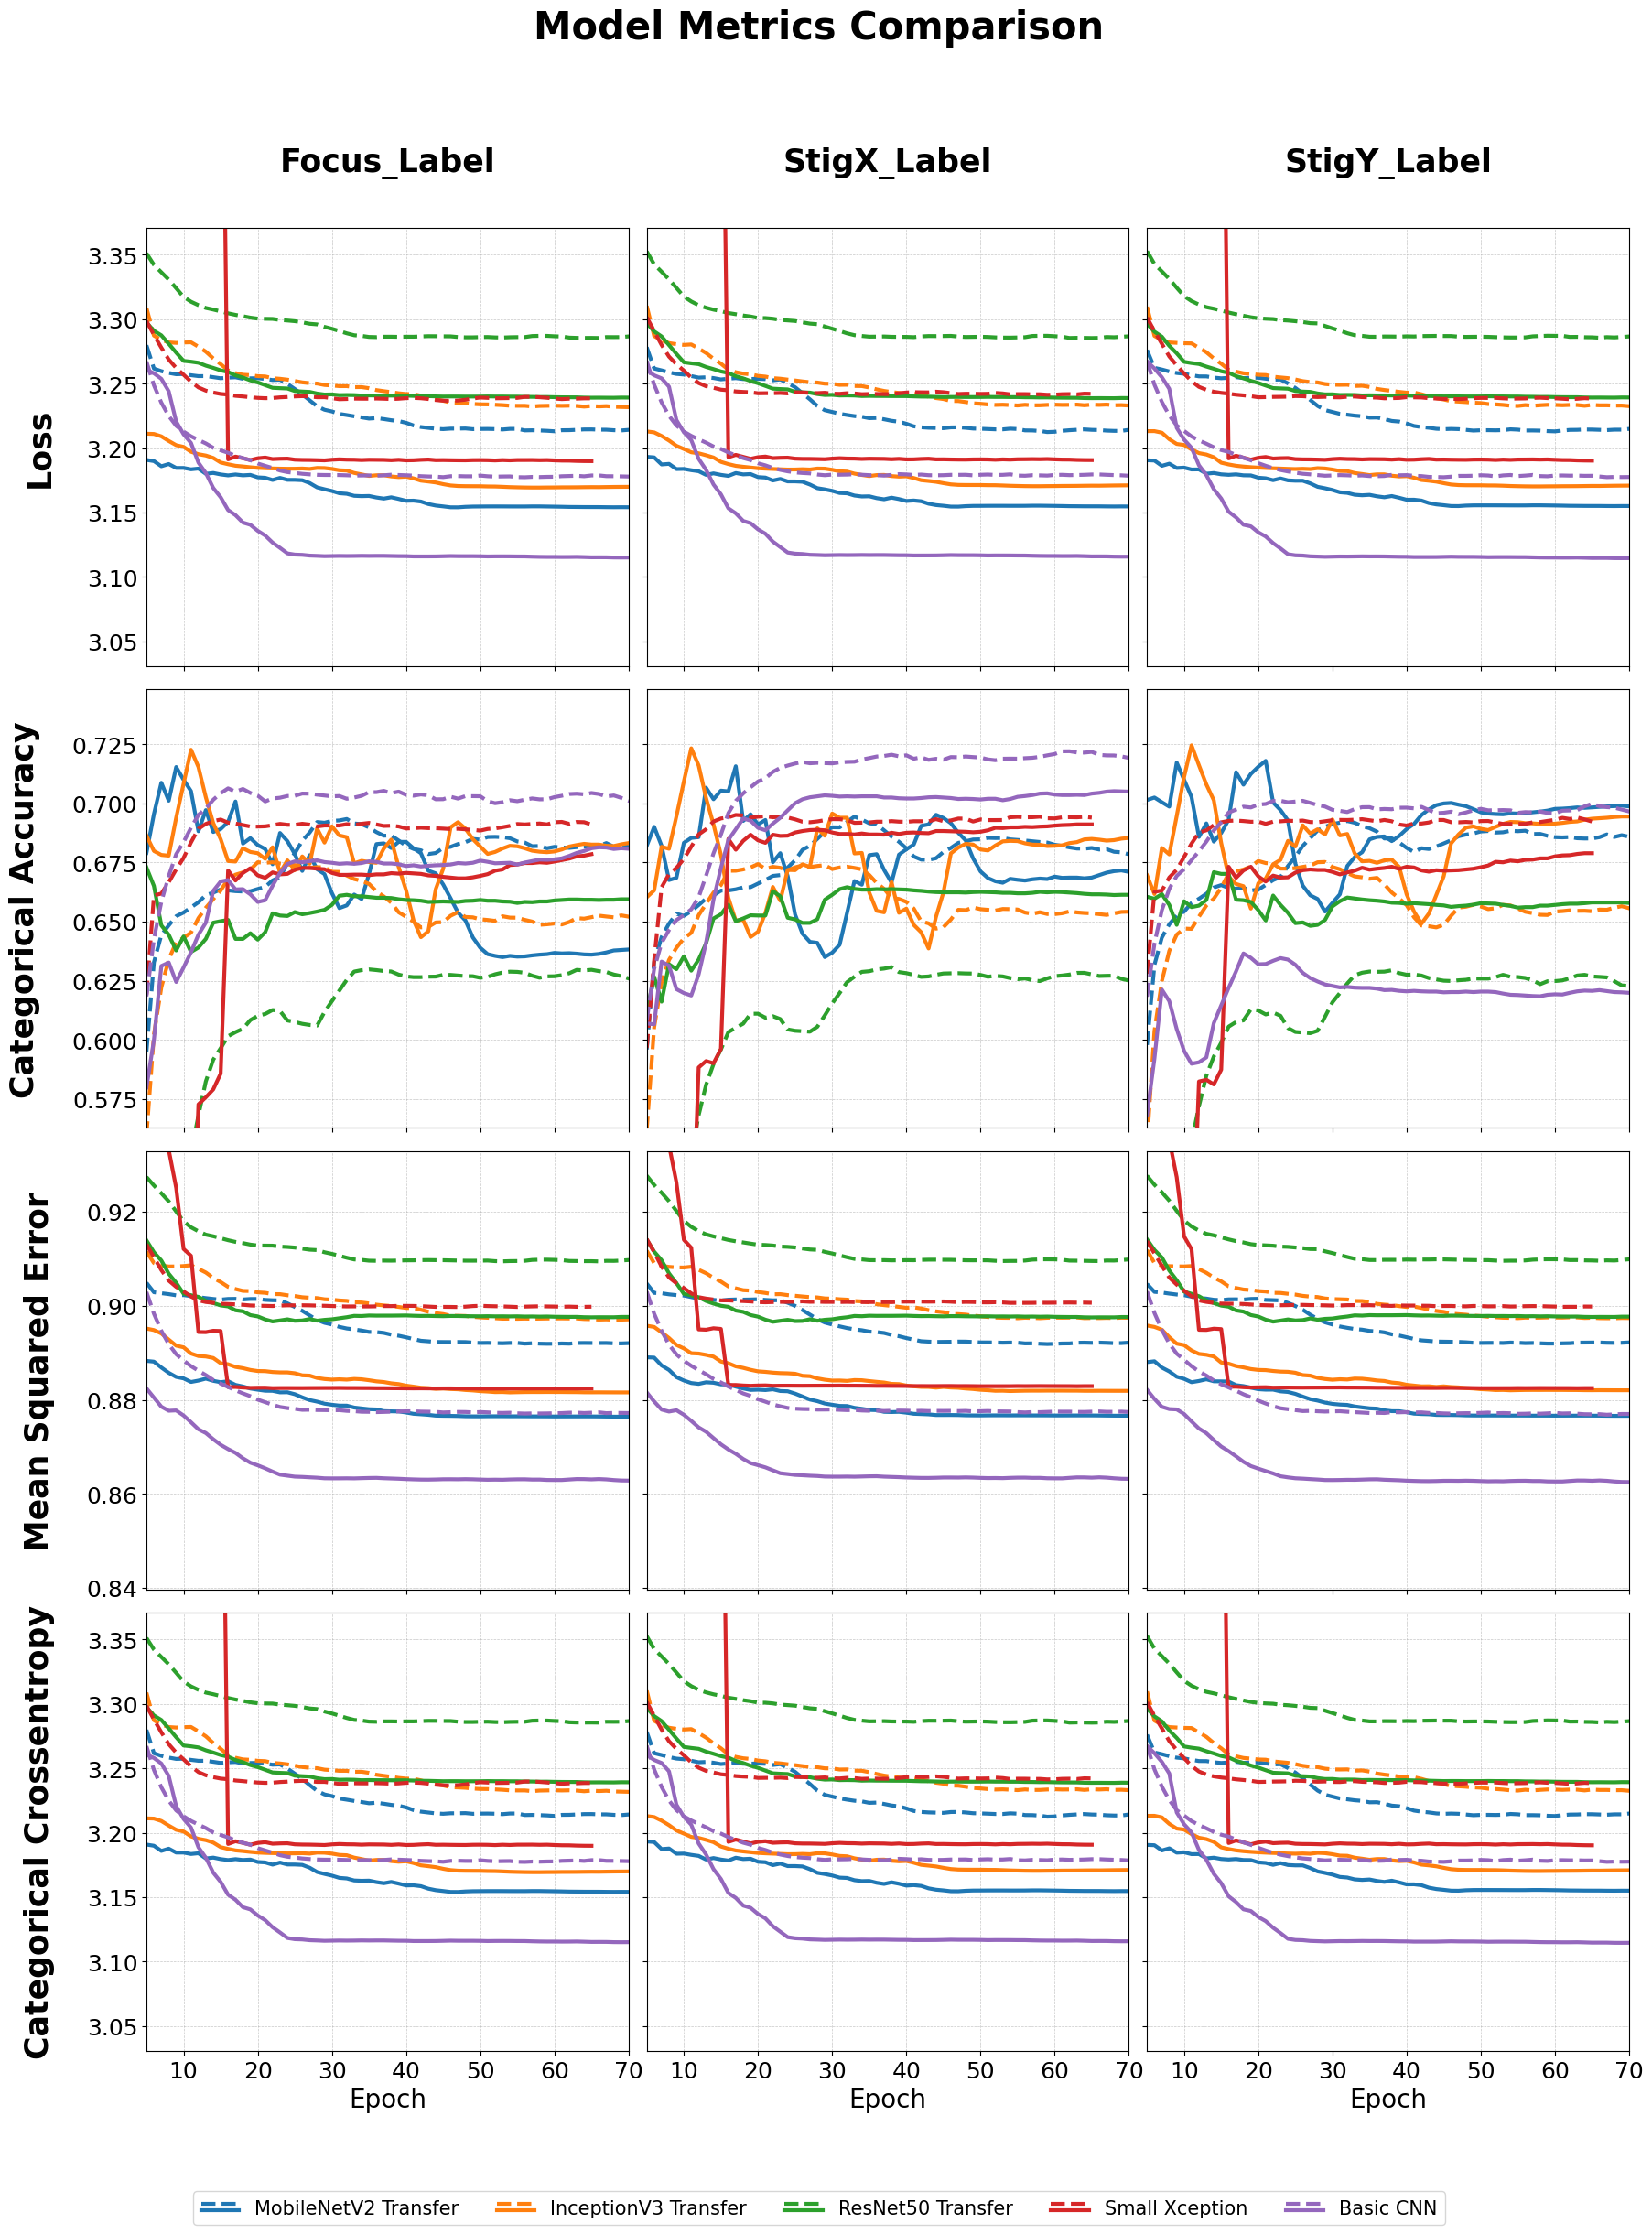

In [2]:
# Define all the necessary functions and classes from the provided code


# Now, execute the function and plot the metrics using the uploaded Excel file
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import numpy as np

# Custom handler for vertical legend tuples
class HandlerTupleVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans)
            leglines.extend(legline)
        return leglines

# Global variables
MODEL_NAME_MAPPING = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}
LABELS = ['Focus_Label', 'StigX_Label', 'StigY_Label']
METRICS = ['loss', 'categorical_accuracy', 'mean_squared_error', 'categorical_crossentropy']
# LABEL_MAPPING = {
#     'Focus_Label': 'Focus',
#     'StigX_Label': 'Stigmatism X',
#     'StigY_Label': 'Stigmatism Y'
# }
# Data processing utilities
def get_metrics_from_dataframe(df):
    return [col for col in METRICS if any(f"{label}_{col}" in df for label in LABELS)]

def get_dataframes_from_excel(xls):
    model_names = xls.sheet_names
    return {model_name: pd.read_excel(xls, model_name) for model_name in model_names}

def get_readable_metric_name(metric):
    mapping = {
        'loss': 'Loss',
        'categorical_accuracy': 'Categorical Accuracy',
        'categorical_crossentropy': 'Categorical Crossentropy',
        'mean_squared_error': 'Mean Squared Error'
    }
    return mapping.get(metric, metric.capitalize())

def moving_average(data, window_size):
    """Compute the moving average of a dataset."""
    return data.rolling(window=window_size).mean()

def publication_ready_plot(excel_path, epoch_range=None, smoothing_window=None):
    """Generate a truly publication-ready grid of plots with all adjustments."""
    # Load data
    xls = pd.ExcelFile(excel_path)
    dfs = get_dataframes_from_excel(xls)
    metrics = get_metrics_from_dataframe(next(iter(dfs.values())))
    
    # Set up color dictionary for models
    model_names = dfs.keys()
    readable_model_names = [MODEL_NAME_MAPPING.get(name, name) for name in model_names]
    model_palette = sns.color_palette("tab10", len(model_names))
    model_color_dict = {readable_name: model_palette[i] for i, readable_name in enumerate(readable_model_names)}
    
    # Create the grid of plots with adjusted settings
    fig, axes = plt.subplots(len(metrics), len(LABELS), figsize=(18, 18 * len(metrics)/len(LABELS)))
    
    # Titles for columns and rows with enhanced font settings
    for j, label in enumerate(LABELS):
        axes[0, j].set_title(label, fontsize=25, fontweight='bold', pad=45)
    for i, metric in enumerate(metrics):
        axes[i, 0].set_ylabel(get_readable_metric_name(metric), fontsize=25, fontweight='bold', labelpad=25)
    
    for i, metric in enumerate(metrics):
        # Enhanced y-limits calculation using percentiles to avoid extreme outliers
        all_values = [value for df in dfs.values() for label in LABELS for value in df[f'{label}_{metric}'].tolist() + df[f'val_{label}_{metric}'].tolist()]
        lower_bound = np.percentile(all_values, 5)
        upper_bound = np.percentile(all_values, 90)
        buffer = (upper_bound - lower_bound) * 0.5  
        
        for j, label in enumerate(LABELS):
            ax = axes[i, j]
            ax.set_ylim(lower_bound - buffer, upper_bound + buffer)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            
            # Optional epoch range
            if epoch_range:
                ax.set_xlim(epoch_range)
            
            # Declutter y-axis and enhance font settings
            if j != 0:
                ax.set_yticklabels([])
            else:
                ax.tick_params(axis='y', labelsize=18)
            # Declutter x-axis and enhance font settings
            if i != len(metrics) - 1:
                ax.set_xticklabels([])
            else:
                ax.tick_params(axis='x', labelsize=18)
                ax.set_xlabel('Epoch', fontsize=20)
            
            for model_name, df in dfs.items():
                readable_model_name = MODEL_NAME_MAPPING.get(model_name, model_name)
                color = model_color_dict[readable_model_name]
                
                # Apply smoothing if specified
                if smoothing_window:
                    train_data = moving_average(df[f'{label}_{metric}'], smoothing_window)
                    val_data = moving_average(df[f'val_{label}_{metric}'], smoothing_window)
                else:
                    train_data = df[f'{label}_{metric}']
                    val_data = df[f'val_{label}_{metric}']
                
                # Plot training data with enhanced line width
                ax.plot(df['epoch'], train_data, '--', color=color, label=f"{readable_model_name}", linewidth=3)
                
                # Plot validation data with enhanced line width
                ax.plot(df['epoch'], val_data, '-', color=color, label=f"{readable_model_name} (Validation)", linewidth=3)
    
    # Handle legend with enhanced font settings
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [(handles[j], handles[j + 1]) for j in range(0, len(handles), 2)]
    fig.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc="lower center", 
               borderaxespad=0.1, ncol=len(dfs), fontsize=15, frameon=True, bbox_to_anchor=(0.5, 0.02))


    # Adjust layout and add a title for the entire figure
    fig.tight_layout()
    fig.subplots_adjust(top=0.93, bottom=0.10)  # Adjust the layout to make space for the legend
    fig.suptitle('Model Metrics Comparison', fontsize=30, fontweight='bold', y=1.03)
    
    plt.show()
    
# excel_path = 'Oct26_100pct_CW_SIM_copy1.xlsx'
excel_path = 'DOE_v1_SIM_noclw.xlsx'
# Generate the truly publication-ready plot with optional smoothing and epoch range
publication_ready_plot(excel_path, epoch_range=(5, 70), smoothing_window=5)



In [3]:
### Comparing Experiment Results (Refactored GraphVersion)


# Global variables
MODEL_NAME_MAPPING = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}


# Constants
FILE_PATHS = [
    "SIM_Unbalanced.xlsx",
    "V9_Laptop - Multi-Output.xlsx",
    "V9.1_Laptop - Multi-Output.xlsx",
]

METRIC_VISUALIZATION_KEYS_WITH_EPOCHS = [
    (
        "Max Validation Categorical Accuracy",
        "Max Validation Categorical Accuracy Across Experiments",
        "Epoch at Max Validation Categorical Accuracy",
    ),
    (
        "Min Validation Loss",
        "Min Validation Loss Across Experiments",
        "Epoch at Min Validation Loss",
    ),
    (
        "Min Validation Categorical Crossentropy",
        "Min Validation Categorical Crossentropy Across Experiments",
        "Epoch at Min Validation Categorical Crossentropy",
    ),
    (
        "Min Validation Mean Squared Error",
        "Min Validation Mean Squared Error Across Experiments",
        "Epoch at Min Validation Mean Squared Error",
    ),
]

def extract_key_metrics_updated(excel_path):
    """Extract key metrics from the provided Excel file without using determine_engine."""
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path, engine="openpyxl")
    dfs = get_dataframes_from_excel(xls)

    return {
        model_name: {
            "Min Validation Loss": df["val_loss"].min(),
            "Epoch at Min Validation Loss": df["epoch"].iloc[
                df["val_loss"].idxmin()
            ],
            "Max Validation Categorical Accuracy": df[
                "val_categorical_accuracy"
            ].max(),
            "Epoch at Max Validation Categorical Accuracy": df["epoch"].iloc[
                df["val_categorical_accuracy"].idxmax()
            ],
            "Min Validation Categorical Crossentropy": df[
                "val_categorical_crossentropy"
            ].min(),
            "Epoch at Min Validation Categorical Crossentropy": df[
                "epoch"
            ].iloc[df["val_categorical_crossentropy"].idxmin()],
            "Min Validation Mean Squared Error": df[
                "val_mean_squared_error"
            ].min(),
            "Epoch at Min Validation Mean Squared Error": df["epoch"].iloc[
                df["val_mean_squared_error"].idxmin()
            ],
        }
        for model_name, df in dfs.items()
    }


def extract_and_map_metrics(excel_path, name_mapping, metric_key, epoch_key):
    """Extract and map metrics using the provided name mapping."""
    experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
    metrics = extract_key_metrics_updated(excel_path)

    # Use the name_mapping to rename models
    mapped_metric_values = {
        name_mapping.get(model, model): data[metric_key] for model, data in metrics.items()
    }
    mapped_epoch_values = {
        name_mapping.get(model, model): data[epoch_key] for model, data in metrics.items()
    }

    return experiment_name, mapped_metric_values, mapped_epoch_values


def visualize_mapped_metrics(metric_data, epoch_data, metric_title, metric_key):
    """Visualize a specific metric across experiments and annotate bars with epoch numbers."""
    metric_df = pd.DataFrame(metric_data).transpose()

    # Create the plot
    plt.figure(figsize=(15, 10))
    ax = metric_df.plot(kind="bar", ax=plt.gca(), colormap="viridis")
    plt.title(metric_title, fontsize=18)
    plt.ylabel(metric_key, fontsize=16)
    plt.xlabel("Experiment", fontsize=16)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    ax.grid(axis='y')
    
    # Annotate bars with epoch numbers
    for idx, rect in enumerate(ax.patches):
        experiment_idx = idx // len(metric_df.columns)
        model_idx = idx % len(metric_df.columns)
        experiment_name = metric_df.index[experiment_idx]
        model_name = metric_df.columns[model_idx]
        epoch_value = epoch_data[experiment_name][model_name]
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f'Ep {epoch_value}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def main_visualization(file_paths, name_mapping, metric_visualization_keys_with_epochs):
    """Main function for visualization."""
    for metric_key, metric_title, epoch_key in metric_visualization_keys_with_epochs:
        metric_data = {}
        epoch_data = {}

        for excel_path in file_paths:
            experiment_name, mapped_metric_values, mapped_epoch_values = extract_and_map_metrics(
                excel_path, name_mapping, metric_key, epoch_key
            )
            metric_data[experiment_name] = mapped_metric_values
            epoch_data[experiment_name] = mapped_epoch_values

        visualize_mapped_metrics(metric_data, epoch_data, metric_title, metric_key)


# Execute the main function
main_visualization(
    FILE_PATHS, model_name_mapping, METRIC_VISUALIZATION_KEYS_WITH_EPOCHS
)

NameError: name 'model_name_mapping' is not defined

### 2. Loading and Testing Classification Models

In [ ]:
### Loading the Best Model from Directories

def get_best_model_filename(directory):
    """Identify the best model filename based on the minimum validation loss from the directory."""
    model_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
    if not model_files:
        print(f"No model files found in {directory}")
        return None
    return min(model_files, key=lambda x: float(x.split('val_loss_')[1].split('_')[0]))

def load_best_model(directory):
    """Loads the best model from the specified directory."""
    best_model_file = get_best_model_filename(directory)
    if not best_model_file:
        return None
    best_model_path = os.path.join(directory, best_model_file)
    # return load_model(best_model_path)
    return load_model(best_model_path, compile=False)

def get_label_directories(experiment_directory):
    """Determine label directories or just model directories in the experiment directory."""
    first_level_dirs = [os.path.join(experiment_directory, d) for d in os.listdir(experiment_directory) 
                        if os.path.isdir(os.path.join(experiment_directory, d))]
    if any('mobilenetv2' in dir_name for dir_name in first_level_dirs):
        return [experiment_directory]
    return first_level_dirs

def load_all_best_models(experiment_directory):
    """Load the best model for each model type within the experiment directory."""
    best_models = {}
    label_dirs = get_label_directories(experiment_directory)
    for label_dir in label_dirs:
        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            best_model = load_best_model(model_dir)
            if best_model:
                key_name = f"{os.path.basename(label_dir)}_{model_name}"
                best_models[key_name] = best_model
    return best_models

# Example Usage
experiment_directory = "SIM_Unbalanced"
all_best_models = load_all_best_models(experiment_directory)
print(all_best_models.keys())  # This will display the keys of the loaded models.

### Investigating and Debugging Classification Models

In [ ]:
### Displaying Model Outputs in a Table (Refactored GraphVersion)

from tabulate import tabulate

def predict_with_model(model, sample_input):
    """Predict the output using the given model and input."""
    output = model.predict(sample_input)
    
    # Convert TensorFlow tensor to numpy array if needed
    if hasattr(output, 'numpy'):
        output = output.numpy()
    
    return output

def capture_model_output_details(model_name, model, sample_input):
    """Capture details of model's output for a given input."""
    output = predict_with_model(model, sample_input)
    return {
        "Model Name": model_name,
        "Input Shape": model.input_shape,
        "Output Shape": output.shape,
        "Output Type": type(output).__name__,
        "Sample Output": output[0] if len(output) > 0 else "No Output"
    }

def display_model_outputs_in_table(all_best_models, sample_input):
    """Display details of model's outputs in a tabular format."""
    model_output_details = [capture_model_output_details(model_name, model, sample_input) 
                            for model_name, model in all_best_models.items()]
    
    print(tabulate(model_output_details, headers="keys", tablefmt="grid"))

# Sample Usage
sample_input = test_images
display_model_outputs_in_table(all_best_models, sample_input)


In [ ]:
### Inspecting the first few samples from the test dataset (Refactored GraphVersion)

def inspect_test_samples(test_dataset, label_encoders, num_samples_to_inspect=3):
    """
    Inspect a specified number of samples from a test dataset.
    
    Args:
    - test_dataset (tf.data.Dataset): The test dataset to inspect.
    - label_encoders (dict): A dictionary of label encoders.
    - num_samples_to_inspect (int, optional): Number of samples to inspect. Defaults to 3.
    
    Returns:
    - df: Styled DataFrame with inspected samples.
    """
    
    # Load a batch of test images, labels, and offset values
    test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(1)))
    # test_images, test_labels_list = next(iter(test_dataset.take(1)))
    test_labels_array = np.stack([np.array(label) for label in test_labels_list])

    # Prepare data for DataFrame
    data = []
    for i in range(num_samples_to_inspect):
        sample_data = {
            "Sample": i + 1,
            "Image shape": str(test_images[i].shape),
            "Image values (first few)": f"{str(test_images[i].numpy().flatten()[:10])}...",
            "Labels shape": str(test_labels_array[i].shape),
            "Labels values": str(test_labels_array[i]),
        }

        for label, value in zip(label_encoders.keys(), test_labels_array[i]):
            sample_data[f"{label} (Decoded)"] = label_encoders[label].inverse_transform([value])[0]

        data.append(sample_data)

    # Create and display DataFrame
    df = pd.DataFrame(data).set_index("Sample")
    return df.style.hide_index()

# Sample Usage
styled_df = inspect_test_samples(train_dataset, label_encoders)
display(styled_df)

In [ ]:
### Displaying Images from the Test Dataset (Refactored GraphVersion)

import numpy as np
import matplotlib.pyplot as plt

def decode_single_label(value, label, label_encoders):
    """Decode a single label."""
    decoded_label = label_encoders[label].inverse_transform([value])[0]
    
    simple_mappings = {
        'SharpFocus': 'Optimal',
        'SlightlyBlurred': 'Moderate',
        'HighlyBlurred': 'Severe',
        'OptimalStig_X': 'Optimal',
        'ModerateStig_X': 'Moderate',
        'SevereStig_X': 'Severe',
        'OptimalStig_Y': 'Optimal',
        'ModerateStig_Y': 'Moderate',
        'SevereStig_Y': 'Severe'
    }
    
    return simple_mappings.get(decoded_label, decoded_label)

def decode_labels(encoded_labels, label_encoders):
    """Decode a set of labels."""
    return [decode_single_label(value, label, label_encoders) for label, value in zip(label_encoders.keys(), encoded_labels)]

def format_label_for_display(label, value, offset):
    """Format the label for display on the image."""
    label = label.replace("_Label", "").replace("StigX", "Astigmatism (X direction)").replace("StigY", "Astigmatism (Y direction)")
    return f"{label}: {value} (Offset: {offset:.2f})"

def display_samples_with_labels(images, decoded_labels, offsets):
    """Display images with their decoded labels."""
    num_samples_to_display = min(3, len(images))
    fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
    for img, labels, offset, ax in zip(images[:num_samples_to_display], 
                                       decoded_labels[:num_samples_to_display], 
                                       offsets[:num_samples_to_display], 
                                       axes):
        ax.imshow(img.numpy())
        formatted_title = [format_label_for_display(label, value, off) for label, value, off in zip(label_encoders.keys(), labels, offset.numpy())]
        ax.set_title("\n".join(formatted_title))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Decode the labels of the test samples
test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(1)))
# test_images, test_labels_list = next(iter(test_dataset.take(1)))

test_labels_array = np.stack([np.array(label) for label in test_labels_list])
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]

# Display the test samples
display_samples_with_labels(test_images, decoded_labels, test_offsets)


### Beta Testing

In [ ]:
# Graph Version Code for Confusion Matrix

from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, encoder=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, output_num=None):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    Args:
    y_true: Array of truth labels.
    y_pred: Array of predicted labels.
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    encoder: Fitted LabelEncoder to transform integer labels back to original string labels.
    ... (other arguments as before)

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
    """
    
    # Error handling for array shapes
    if y_true.shape != y_pred.shape:
        print(f"Error: Mismatch in shapes of y_true ({y_true.shape}) and y_pred ({y_pred.shape}). Skipping this output.")
        return
    
    if encoder:
        y_true = encoder.inverse_transform(y_true)
        y_pred = encoder.inverse_transform(y_pred)
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    labels = classes if classes else np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = f"{cm[i, j]}" if not norm else f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)"
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, text, horizontalalignment="center", color=color, size=text_size)

    # Save the figure to the current working directory
    if savefig and output_num is not None:
        fig.savefig(f"confusion_matrix_output_{output_num + 1}.png")




def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, encoders=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

    Args:
    y_true: 2D array of truth labels for multiple outputs.
    y_preds: 2D array of predicted labels for multiple outputs.
    classes: List of arrays of class labels (e.g. string form) for each output. If `None`, integer labels are used.
    encoders: List of fitted LabelEncoders to transform integer labels back to original string labels for each output.
    ... (other arguments as before)

    Returns:
    A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
    """
    
    # Error handling for array shapes
    if y_true.shape != y_preds.shape:
        print(f"Error: Mismatch in shapes of y_true ({y_true.shape}) and y_preds ({y_preds.shape}). Cannot proceed.")
        return
    
    num_outputs = y_true.shape[1]
    
    for i in range(num_outputs):
        print(f"Confusion Matrix for Output {i + 1}:")
        encoder = encoders[i] if encoders else None
        make_confusion_matrix(y_true[:, i], np.argmax(y_preds[:, i], axis=1), classes[i] if classes else None, encoder, figsize, text_size, norm, savefig, i)
        plt.show()


In [ ]:
### Function for Confusion Matrix

def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

    Args:
    y_true: List of arrays of truth labels (must be same shape as y_preds).
    y_preds: List of arrays of predicted labels (must be same shape as y_true).
    classes: List of arrays of class labels (e.g. string form). If `None`, integer labels are used.
    ... (other arguments as before)

    Returns:
    A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
    """
    # Check if y_true and y_preds are lists, if not, convert them to lists (for single-output compatibility)
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_preds, list):
        y_preds = [y_preds]
    
    for i, (true, pred) in enumerate(zip(y_true, y_preds)):
        print(f"Output {i + 1}:")
        make_confusion_matrix(true, pred, classes[i] if classes else None, figsize, text_size, norm, savefig)
        plt.show()

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # (The function content remains the same as you provided)

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    labels = classes if classes else np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig(f"confusion_matrix_output_{i + 1}.png")
        
        
        
### Attempt at Using the Confusion Matrix Function

def extract_labels_from_dataset(dataset, problem_type):
    """
    Extract labels from a TensorFlow dataset based on the problem type.
    
    Args:
    - dataset (tf.data.Dataset): The TensorFlow dataset to extract labels from.
    - problem_type (str): The type of problem ('Multi-Output', 'Multi-Class', or 'Binary').
    
    Returns:
    - numpy array or dict: If 'Multi-Output', returns a numpy array with shape (num_samples, num_outputs).
                           If 'Multi-Class' or 'Binary', returns a dictionary with label types as keys and 
                           arrays of labels as values.
    """
    
    if problem_type == 'Multi-Output':
        labels_list = [labels for _, labels in dataset]
        return np.array(labels_list).squeeze()

    elif problem_type in ['Multi-Class', 'Binary']:
        labels_dict = {}
        for label_type in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
            label_data = []
            for _, labels in dataset[label_type]:
                label_data.extend(labels.numpy())
            labels_dict[label_type] = np.array(label_data)
        return labels_dict

    else:
        print(f"Unknown problem type: {problem_type}")
        return None

# Usage
problem_type = config['Experiment']['PROBLEM_TYPE']
test_labels = extract_labels_from_dataset(test_dataset, problem_type)

# Choose a specific model (replace 'specific_model_name' with the actual model name you're interested in)
model_name = 'specific_model_name'
model = all_best_models[model_name]

if not model:
    print(f"No model found for {model_name}")
    exit()

# 1. Predict on the test data
predictions = model.predict(test_dataset)


# 2. Get true labels and predictions for each output
# Assuming test_labels is a list where each item is an array of true labels for a given output
true_labels = [test_labels[i] for i in range(len(predictions))]
predicted_labels = [np.argmax(predictions[i], axis=1) for i in range(len(predictions))]

# List of class names for each output, assuming they are the same for all outputs in this example
classes_list = [list(range(3)) for _ in range(len(predictions))]

# 3. Generate confusion matrices
make_confusion_matrix_multi_output(true_labels, predicted_labels, classes_list)


### TODO: Incorporate into main notebook

In [ ]:
def display_labels_with_probabilities(decoded_labels, probabilities):
    """
    Construct display strings that combine decoded labels with their corresponding probabilities.
    
    Parameters:
    - decoded_labels: A list of decoded label strings.
    - probabilities: A list of probability values corresponding to the decoded labels.
    
    Returns:
    - A list of strings combining labels with their probabilities.
    """
    return [f"{label} ({prob:.2f})" for label, prob in zip(decoded_labels, list(probabilities))]

# Load a batch of test images and labels
test_images, test_labels_list = next(iter(test_dataset.take(1)))
test_labels_array = np.stack([np.array(label) for label in test_labels_list])

# Make predictions using the selected model
predictions = model.predict(test_images)

# Decode the labels of the first few samples
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]
# Extract probabilities for the predicted labels
predicted_probs = [predictions[i][np.argmax(predictions[i])] for i in range(predictions.shape[0])]
display_strings = [display_labels_with_probabilities(labels, probs) for labels, probs in zip(decoded_labels, predicted_probs)]

# Display the images along with their decoded labels and probabilities
num_samples_to_display = 3
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
for img, labels_with_probs, ax in zip(test_images[:num_samples_to_display], display_strings[:num_samples_to_display], axes):
    ax.imshow(img)
    title = "\n".join(labels_with_probs)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_labels, pred_classes))

# Note on classification_report():
# - Precision: Proportion of true positives. Higher precision -> fewer false positives.
# - Recall: Proportion of true positives over actual positives. Higher recall -> fewer false negatives.
# - F1 score: Harmonic mean of precision and recall. Range: [0, 1].

# Convert the report to a dictionary for further processing
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Focusing on f1-score as it combines precision and recall, extract it into a new dictionary
class_f1_scores = {class_names[int(k)]: v["f1-score"] for k, v in classification_report_dict.items() if k != "accuracy"}

class_f1_scores

# Convert dictionary to DataFrame and sort by f1-score in descending order
f1_scores_df = pd.DataFrame({
    "class_name": class_f1_scores.keys(),
    "f1-score": class_f1_scores.values()
}).sort_values("f1-score", ascending=False)

# Visualize f1-scores using a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 25))
bars = ax.barh(f1_scores_df["class_name"], f1_scores_df["f1-score"])
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for Different Classes")
ax.invert_yaxis()  # Reverse order for clarity

# Annotate bars with their respective scores
for bar in bars:
    ax.text(bar.get_width() * 1.03, bar.get_y() + bar.get_height() / 1.5,
            f"{bar.get_width():.2f}", ha='center', va='bottom')


In [ ]:
# Analyzing Most Wrong Predictions:
# Observing predictions with high confidence but incorrect can provide insights into model performance.
# Steps:
# 1. Get test image filepaths.
# 2. Create a DataFrame for image details and predictions.
# 3. Identify correct predictions.
# 4. Extract top 100 most confidently incorrect predictions.
# 5. Visualize some of the most wrong examples.

# 1. Get the filenames of all test data
filepaths = [filepath.numpy() for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False)]

# 2. Create a dataframe for prediction analysis
import pandas as pd
pred_df = pd.DataFrame({
    "img_path": filepaths,
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": pred_probs.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]
})

# 3. Identify correct predictions
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

# 4. Extract top 100 confidently incorrect predictions
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False).head(100)

# 5. Visualize some of the most wrong examples
images_to_view = 9
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong.head(images_to_view).itertuples()): 
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row.img_path, scale=True)
    plt.imshow(img)
    plt.title(f"actual: {row.y_true_classname}, pred: {row.y_pred_classname} \nprob: {row.pred_conf:.2f}")
    plt.axis(False)
